# Sequential Models
In this lecture we will cover the basics of sequential models as well as a primer on building your own dataset class for training. Homework 3 has been assigned at this point and you will need to build your own dataset class to train your model on your dataset. 

In [1]:
import numpy as np
from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import lightning as pl
from torch.utils import data
import matplotlib.pyplot as plt
import torch.utils.data
from tqdm import tqdm
import pandas as pd
import requests
import csv
from sklearn.preprocessing import MinMaxScaler

/software/u20/anaconda/python3.7/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We will demonstrate sequential models and building your own dataset class on these open source time-series datasets. Both datasets are univariate time series data. The airline dataset is for monthly international airline passengers and the shampoo data is for monthly shampoo sales. 

We could easily download these datasets into a pandas dataframe and carry out the train/test split, covert to tensors, and forego a dataloader, but that methodology will not scale to larger datasets and is bad practice in general. So we are going to download these datasets, save to the local directory and build our own dataset class. 

In [2]:
# download time series datasets from github and save to local directory
airline_data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
response = requests.get(airline_data_url)

# Save the file in the current directory
with open('airline_data.csv', 'w') as f:
    writer = csv.writer(f)
    for line in response.iter_lines():
        writer.writerow(line.decode('utf-8').split(','))

shampoo_data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
response = requests.get(shampoo_data_url)

# Save the file in the current directory
with open('shampoo_data.csv', 'w') as f:
    writer = csv.writer(f)
    for line in response.iter_lines():
        writer.writerow(line.decode('utf-8').split(','))

In [3]:
df = pd.read_csv('airline_data.csv')
print(df.shape)

(145, 2)


shape of data -  (145, 2)


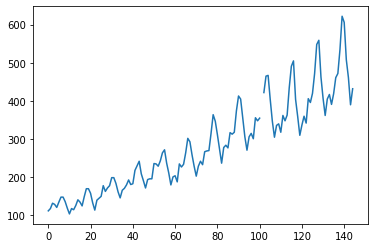

In [4]:
# view data
df = pd.read_csv('airline_data.csv')
print('shape of data - ',df.shape)

# visualize data
plt.plot(df.iloc[:,1:2].values)
plt.show()

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

training_set = df.iloc[:,1:2].values

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

In [6]:
print(x.shape)
print(y.shape)

(140, 4, 1)
(140, 1)


### Time-Series Data

Let's add some context to our goal for time-series prediction. 

We are given this dataset, where the x-axis is time and the y-axis is some value, in our case either shampoo sales or number of international passengers. The above figure is international passengers and clearly displays that as time has progressed the number of international travelers has increased. 

The goal of time-series is given some controllable information, oftentimes __time__, can we predict the corresponding value? So, in 2 months what will the number of international passengers be? Equally, we know that neural networks are more accurate when given more information, so what if we give the neural network a sequence of days and have it predict the subsequent value. So, we give it the values for timesteps 1-10 and have it predict the 11th value. To stack subsets of days together in this data we'll define a 'sliding window' function to package a sequence of days together in a single sample. 

## Sequential Modeling

#### Long Short Term Memory
A long short-term memory (LSTM) network is a type of recurrent neural network (RNN) that is specifically designed to address the problem of vanishing gradients that can occur in traditional RNNs. LSTMs are widely used for tasks that involve processing sequences of data, such as natural language processing, speech recognition, and time series prediction. LSTMs have a memory cell that is able to maintain information over long periods of time. The memory cell is controlled by three gates: the input gate, the forget gate, and the output gate. These gates are responsible for controlling the flow of information into and out of the memory cell, allowing the network to selectively store or discard information as needed. At each time step, the input gate determines which elements of the input should be used to update the memory cell. The forget gate determines which elements of the current memory cell state should be retained or discarded. The output gate determines which elements of the memory cell state should be used to produce the output. LSTMs have been shown to be highly effective for a wide range of sequence processing tasks. They are particularly well-suited for tasks that involve long-term dependencies or where context from earlier parts of the sequence is important for understanding later parts.



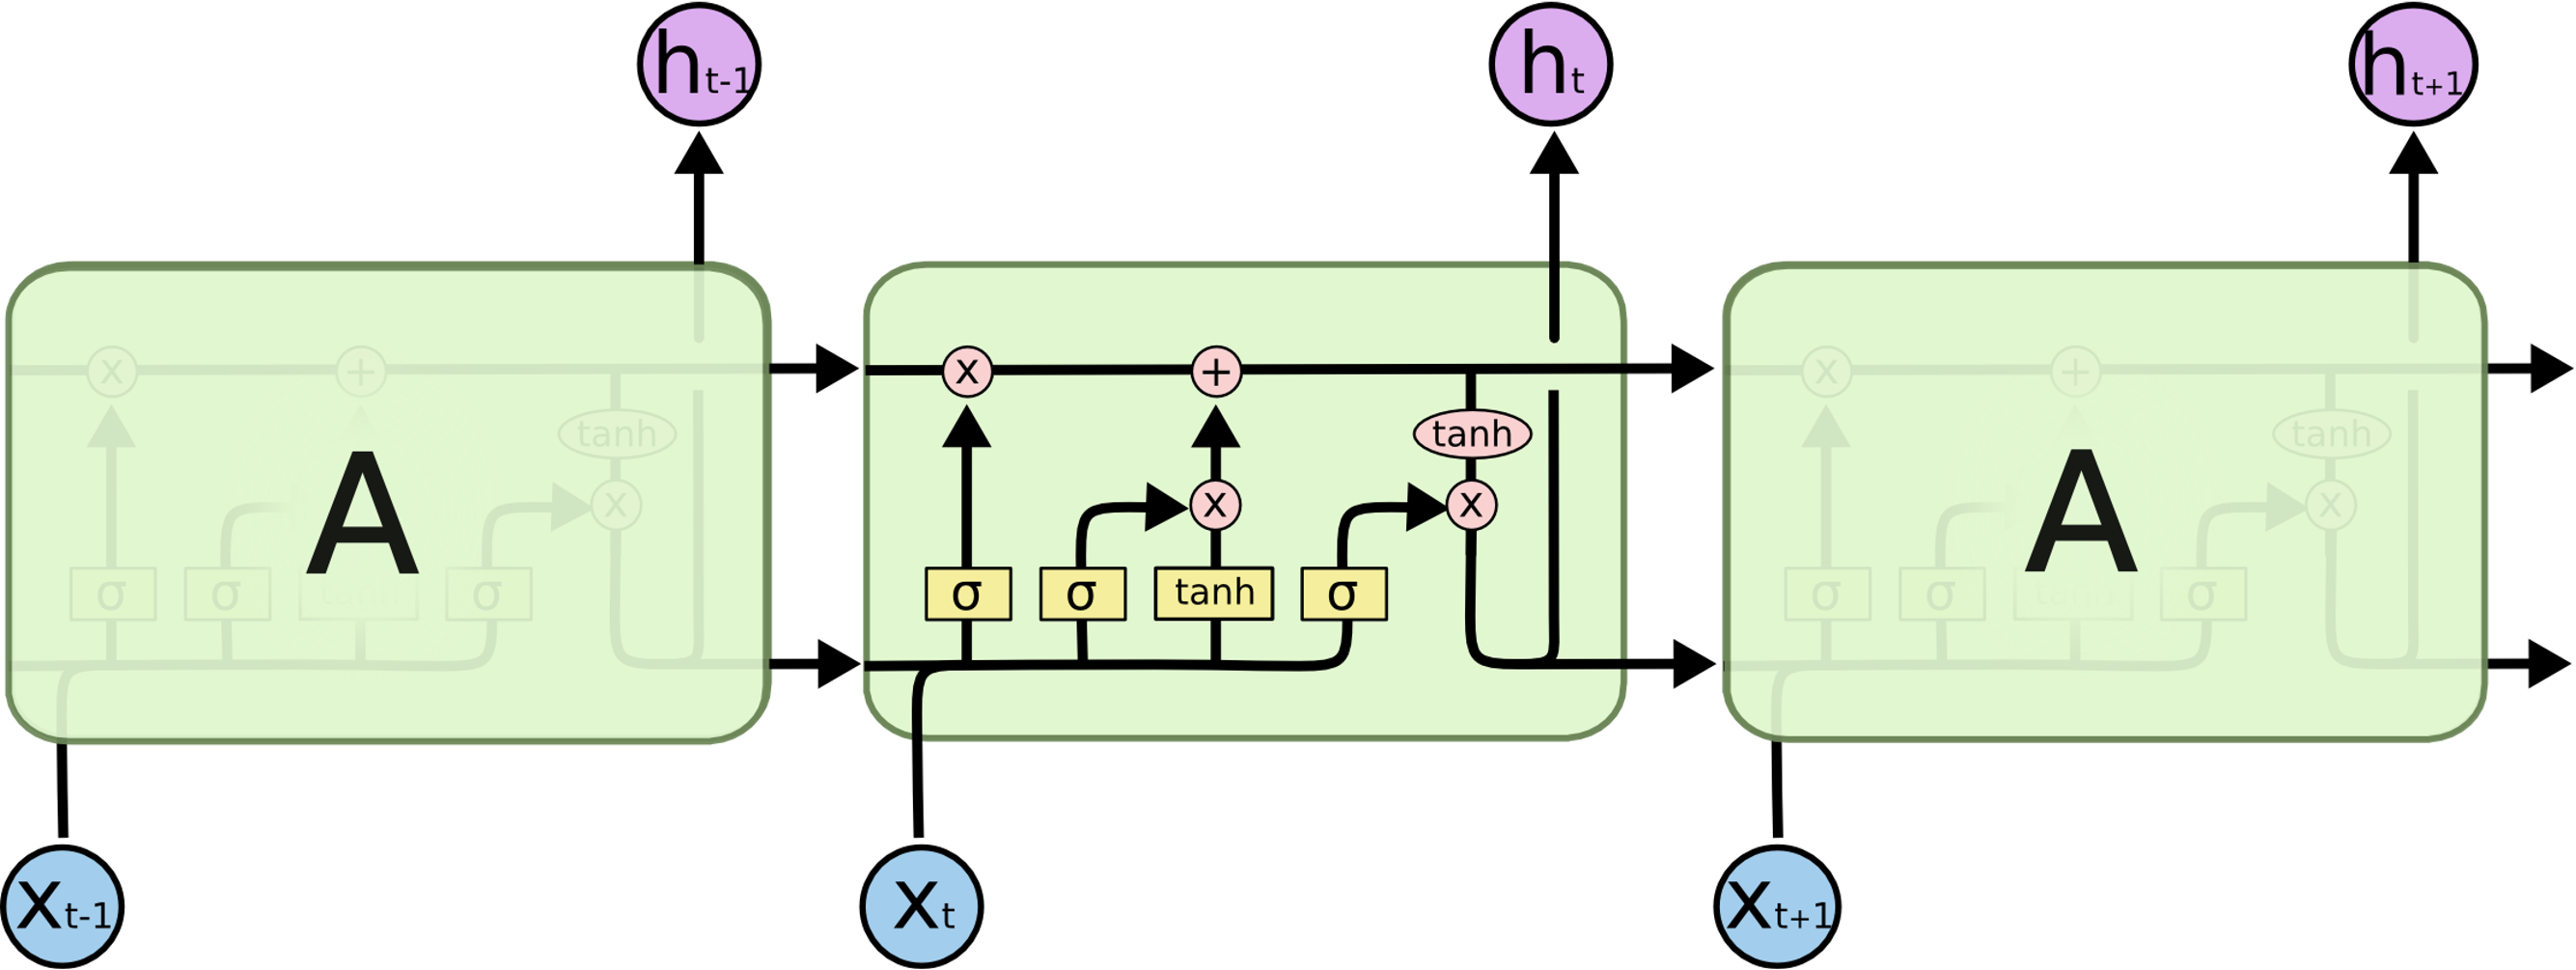



For more information please read https://colah.github.io/posts/2015-08-Understanding-LSTMs/.




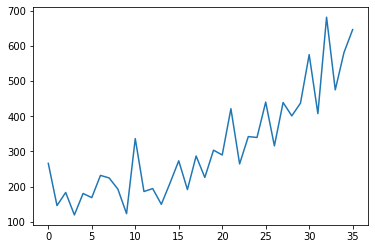

In [137]:
# training_set = pd.read_csv('airline_data.csv')
training_set = pd.read_csv('shampoo_data.csv')

training_set = training_set.iloc[:,1:2].values

plt.plot(training_set, label = 'Shampoo Sales Data')
# plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()


def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

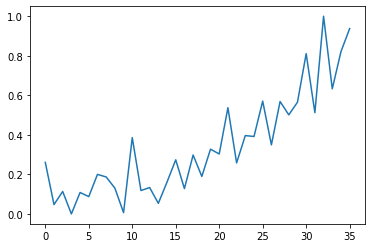

In [138]:
# after normalization
plt.plot(training_data, label = 'Shampoo Sales Data')
# plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

In [146]:
print(trainX[0].shape)
print(trainY[0].shape)
print(trainX.shape)
print(trainY.shape)

torch.Size([4, 1])
torch.Size([1])
torch.Size([20, 4, 1])
torch.Size([20, 1])


In [140]:
class LSTM(nn.Module):
    '''
    Psuedocode for LSTM Cell from PyTorch Source code
        >>> rnn = nn.LSTMCell(10, 20)  # (input_size, hidden_size)
        >>> input = torch.randn(2, 3, 10)  # (time_steps, batch, input_size)
        >>> hx = torch.randn(3, 20)  # (batch, hidden_size)
        >>> cx = torch.randn(3, 20)
        >>> output = []
        >>> for i in range(input.size()[0]):
        ...     hx, cx = rnn(input[i], (hx, cx))
        ...     output.append(hx)
        >>> output = torch.stack(output, dim=0)
    '''

    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [141]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 64
num_layers = 1

num_classes = 1

# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, device)
lstm.to(device)
print("Number of parameters: ", sum(p.numel() for p in lstm.parameters()))

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Number of parameters:  17217
Epoch: 0, loss: 0.11929
Epoch: 100, loss: 0.01082
Epoch: 200, loss: 0.00975
Epoch: 300, loss: 0.00182
Epoch: 400, loss: 0.00005
Epoch: 500, loss: 0.00008
Epoch: 600, loss: 0.00001
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00000
Epoch: 1200, loss: 0.00000
Epoch: 1300, loss: 0.00000
Epoch: 1400, loss: 0.00000
Epoch: 1500, loss: 0.00000
Epoch: 1600, loss: 0.00000
Epoch: 1700, loss: 0.00000
Epoch: 1800, loss: 0.00000
Epoch: 1900, loss: 0.00000


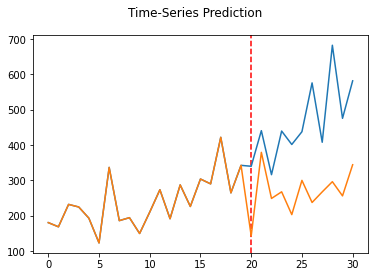

In [142]:
lstm.eval()
train_predict = lstm(dataX.to(device))

data_predict = train_predict.data.cpu().numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

#### Transformer
The Transformer is a neural network architecture that was introduced in the paper "Attention is All You Need" by Vaswani et al. (2017) for sequence-to-sequence learning tasks such as machine translation. It has since become a popular model for a wide range of tasks, including language modeling, image captioning, and even speech recognition.

At a high level, the Transformer consists of an encoder and a decoder, each composed of a stack of layers. Each layer in the encoder and decoder contains two sublayers: a self-attention mechanism and a feedforward neural network. The self-attention mechanism allows the model to weigh the importance of different parts of the input sequence when making predictions, while the feedforward neural network applies a nonlinear transformation to the input.

In the self-attention mechanism, the model computes a query, a key, and a value for each position in the input sequence, using a learned weight matrix. The model then computes a weighted sum of the values, where the weights are determined by the dot product of the query and key, scaled by the square root of the dimensionality of the query and key vectors. This produces a context vector for each position in the input sequence, which is used as input to the feedforward neural network.

The Transformer also incorporates positional encoding, which allows the model to take into account the position of each element in the input sequence. The positional encoding is added to the input embeddings before being fed into the encoder.

Overall, the Transformer architecture has been shown to be highly effective for a wide range of sequence modeling tasks, and has become a popular choice for natural language processing and other related fields.

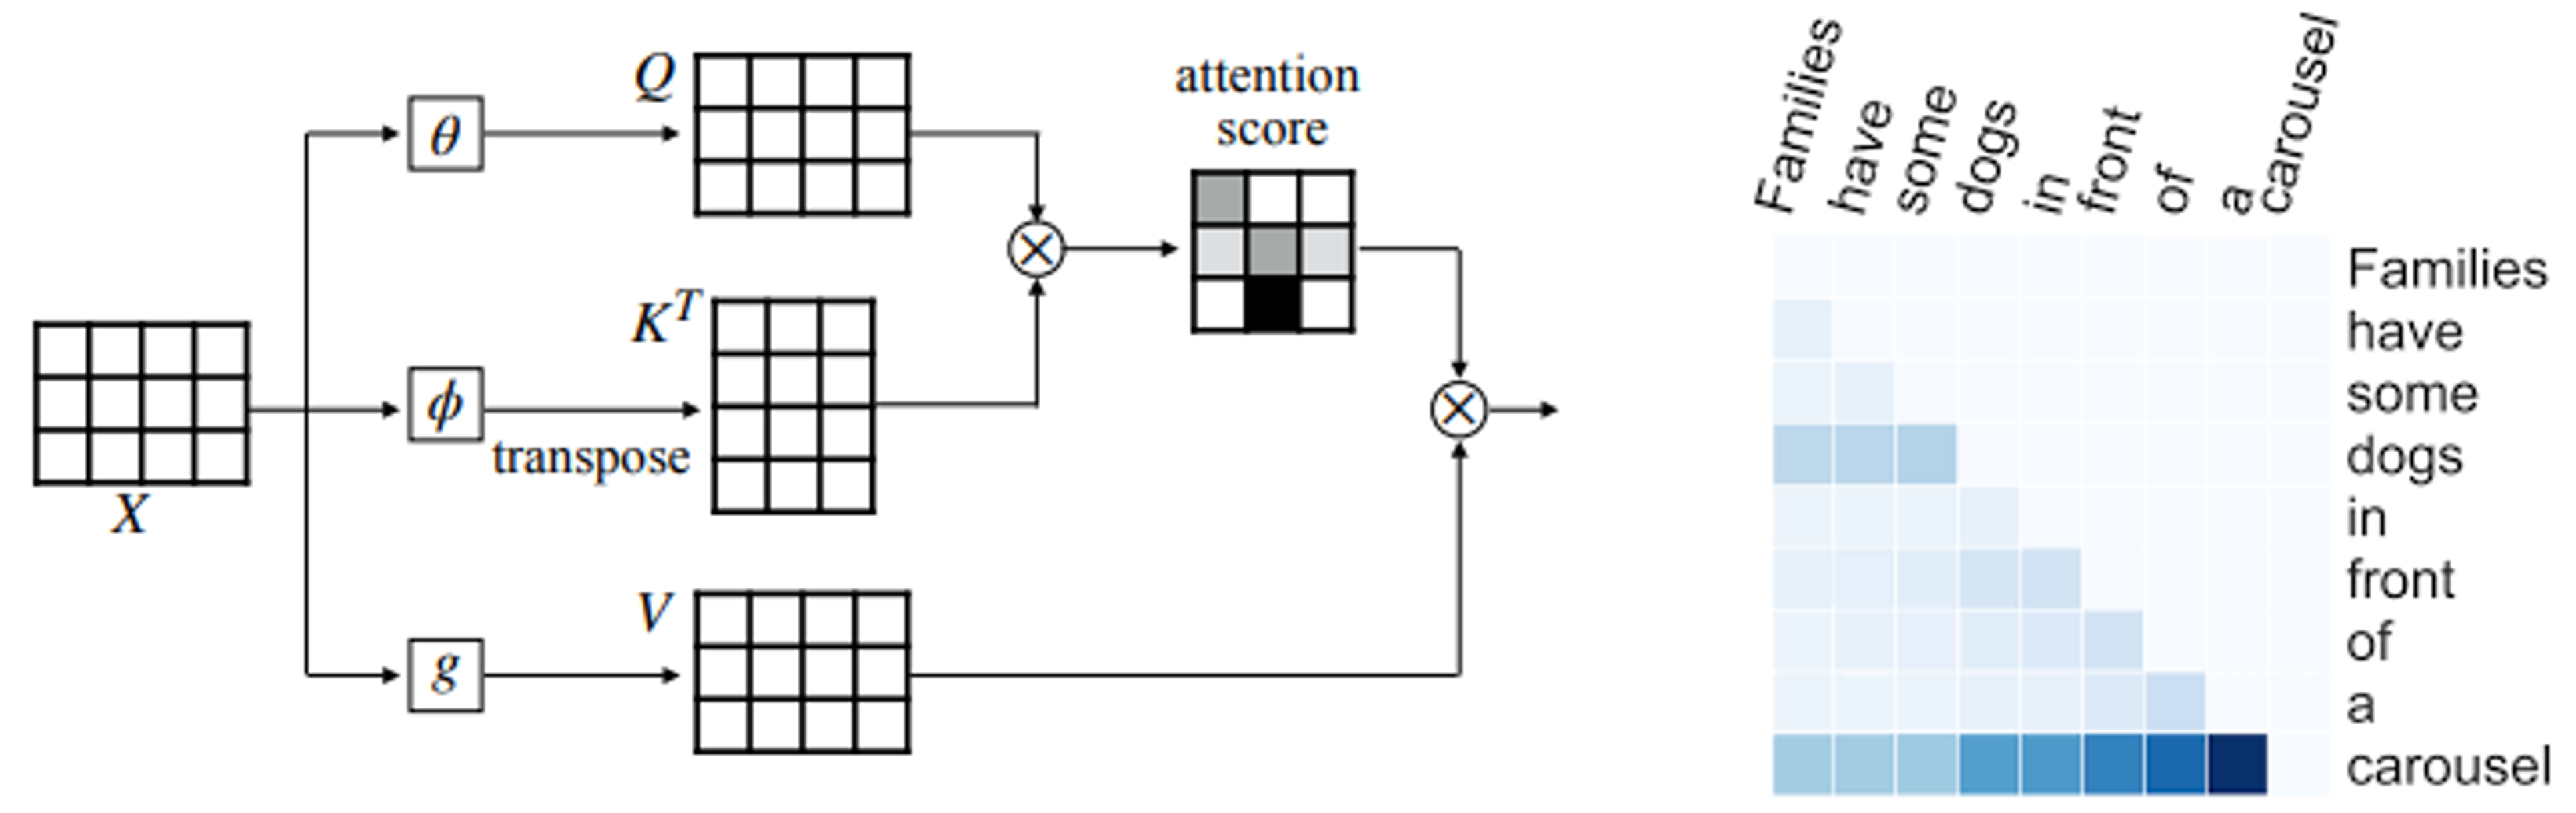


For more information please read https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/. And/or watch https://youtu.be/kCc8FmEb1nY.


In [152]:
import torch
import torch.nn as nn
import math
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.src_embed = nn.Linear(input_size, d_model)
        self.transformer_encoder = TransformerEncoder(num_layers, d_model, nhead, dim_feedforward=128, dropout=0.1)
        self.fc = nn.Linear(16, output_size)

    def forward(self, src):
        # src: [batch_size, sequence_len, input_size]

        # Apply linear transformation to input sequence to embed it to d_model dimension
        src = self.src_embed(src)

        # Transpose input sequence to [sequence_len, batch_size, d_model]
        src = src.transpose(0, 1)

        # Apply transformer encoder
        src = self.transformer_encoder(src)

        # Take the last sequence element as output
        output = rearrange(src, 'seq batch_size v -> batch_size (seq v)')

        # Apply linear layer to output
        output = self.fc(output)

        # Return output
        return output

    
    
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
    
    
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), #nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
    
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
    

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dim_feedforward, dropout):
        super(TransformerEncoder, self).__init__()
        
        
        self.layers = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                PreNorm(d_model, Attention(d_model, nhead, dim_head=16, dropout=dropout)),
                PreNorm(d_model, FeedForward(d_model, dim_feedforward, dropout))
            ]))
                               
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [153]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

model = TransformerModel(input_size=1, output_size=1, d_model=4, nhead=1, num_layers=1, dropout=0.1)
model.to(device)
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Epoch: 0, loss: 0.10146
Epoch: 100, loss: 0.01195
Epoch: 200, loss: 0.01006
Epoch: 300, loss: 0.00873
Epoch: 400, loss: 0.00698
Epoch: 500, loss: 0.00575
Epoch: 600, loss: 0.00581
Epoch: 700, loss: 0.00664
Epoch: 800, loss: 0.00602
Epoch: 900, loss: 0.00554
Epoch: 1000, loss: 0.00483
Epoch: 1100, loss: 0.00727
Epoch: 1200, loss: 0.00474
Epoch: 1300, loss: 0.00457
Epoch: 1400, loss: 0.00637
Epoch: 1500, loss: 0.00377
Epoch: 1600, loss: 0.00294
Epoch: 1700, loss: 0.00300
Epoch: 1800, loss: 0.00572
Epoch: 1900, loss: 0.00334
Number of parameters:  1457


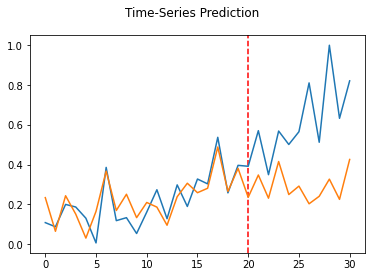

In [154]:
model.eval()
# model.to(device)
train_predict = model(dataX.to(device))

data_predict = train_predict.data.cpu().numpy()
dataY_plot = dataY.data.numpy()
# data_predict = sc.inverse_transform(data_predict)
# dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

## Boilerplate code for Deep Learning

### Building a PyTorch dataset class

From a 30k ft view, the general pipeline of a neural network is Dataset -> Dataloader -> Neural Network. In other words, the dataset class organizes your dataset and defines how the dataloader delivers data to your neural network, the dataloader function is the middleman between the organized dataset (from the dataset class) and the neural network, and the neural network operates on the data handed off by the dataloader. 

##### Dataset

The pytorch dataset class is composed of three main functions; __ init __(), __ len __(), and __ getitem __(). 

The __init__() function is where you initialize any variables that are required to pull/organize/alter your data before being passed to your network and/or dataloader. 

The __len__() function defines the length, or total number of samples in your dataset. This may seem potentially trivial, but is required to define how many batches the dataloader will need to retrieve per epoch. 

The __getitem__() function defines how the data is packaged before being handed off to the dataloader. 

We can think of this in terms of a Coca-Cola distributer and a grocery store. The grocery store is the neural network, the Coca-Cola warehouse is the dataset class, and the Coca-Cola trucks are the dataloader. 
The Coca-Cola warehouse has a massive stock of coke cans, all packaged in large wooden crates with each wooden crate containing 5 paletes of coke cans. The __init__() function is going to define where the wooden crates are, with an address or other defining attributes. The __len__() function is going to define how many cans are in each palete, how many paletes are in each wooden crate and how many wooden crates there are in total. The __getitem__() function is going to define the function, or how-to, remove the paletes of coke cans from the wooden crates. 

##### Dataloader

The pytorch dataloader function takes in a few different arguments, the two most important are the dataset itself, and the batch size. 

Continuing with the analogy, the dataloader, or Coca-Cola trucks, are going to be told where the Coca-Cola warehouse is (data path), how many cans are in a palete (batch size) and how many paletes (number of batches in dataset) they are supposed to take from the warehouse to the grocery store (neural network). 


With this in mind lets build a dataset for the time series data we have downloaded. Starting with the passenger data. 

In [253]:
df = pd.read_csv('airline_data.csv')
print(df.shape)

(145, 2)


shape of data -  (145, 2)


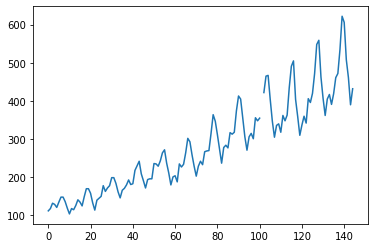

In [254]:
# view data
df = pd.read_csv('airline_data.csv')
print('shape of data - ',df.shape)

# visualize data
plt.plot(df.iloc[:,1:2].values)
plt.show()

In [255]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

training_set = df.iloc[:,1:2].values

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

In [256]:
print(x.shape)
print(y.shape)

(140, 4, 1)
(140, 1)


In [257]:
class AirlineDataset(data.Dataset):
    '''
    Pytorch dataset class for the airline passenger time-series dataset
    '''
    def __init__(self, data_path, num_timesteps, dataset_type='train'):
        self.data_path = data_path
        self.num_timesteps = num_timesteps
        self.type = dataset_type
        
        # load and normalize data from csv
        data = pd.read_csv(self.data_path)
        sc = MinMaxScaler()
        self.data = sc.fit_transform(data.iloc[:,1:2].values)
        
        # convert to time series shape
        timeseries_data = self.sliding_window()
        
        num_samples = len(timeseries_data)
        
        if self.type == 'train':
            self.timeseries_data = timeseries_data[:int(num_samples*0.7)]
        else:
            self.timeseries_data = timeseries_data[int(num_samples*0.7):]
        
        
    def __len__(self):
        return len(self.timeseries_data)
    
    def __getitem__(self, index):
        seq = torch.FloatTensor(self.timeseries_data[index][0])
        next_val = torch.FloatTensor(self.timeseries_data[index][1])
        return seq, next_val
    
    def sliding_window(self):
        x = []
        y = []
        for i in range(len(self.data)-self.num_timesteps):
            x.append(self.data[i:(i+self.num_timesteps)])
            y.append(self.data[i+self.num_timesteps])
        # convert to numpy array of tuples
        return np.array(list(zip(x, y)), dtype=object)

In [258]:
dataset = AirlineDataset('airline_data.csv', 4, 'train')

In [259]:
print(type(dataset))

x, y = dataset[0]
print(type(x))
print(type(y))

print(x.shape)
print(y.shape)

<class '__main__.AirlineDataset'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([4, 1])
torch.Size([1])


In [260]:
# verify with a different sequence value
dataset = AirlineDataset('airline_data.csv', 8, 'val')
print(type(dataset[0]))
x, y = dataset[0]
print(type(x))
print(type(y))
print(x.shape)
print(y.shape)

<class 'tuple'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([8, 1])
torch.Size([1])


#### Pytorch Lightning
Pytorch lightning is an abstraction of pytorch which organizes your boilerplate code, i.e. it makes your life way easier.

In [ ]:
class AirlineTrainer(pl.LightningModule):
    def __init__(self,
                nn_model
                ):
        super(AirlineTrainer, self).__init__()
        self.nn_model = nn_model

    def forward(self, x):
        return self.nn_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.nn_model(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.nn_model(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        lr = 1e-4
        opt = torch.optim.Adam(self.nn_model.parameters(), lr=lr)
        return opt